# Линейная регрессия. Задача 1


__Ильичёв А.С., 693__

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline

#### 1. Считаем данные и проведем их предобработку.

In [2]:
df = pd.read_csv('forestfires.csv')

In [3]:
df.head()

,X,Y,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area
0,7,5,mar,fri,86.2,26.2,94.3,5.1,8.2,51,6.7,0.0,0.0
1,7,4,oct,tue,90.6,35.4,669.1,6.7,18.0,33,0.9,0.0,0.0
2,7,4,oct,sat,90.6,43.7,686.9,6.7,14.6,33,1.3,0.0,0.0
3,8,6,mar,fri,91.7,33.3,77.5,9.0,8.3,97,4.0,0.2,0.0
4,8,6,mar,sun,89.3,51.3,102.2,9.6,11.4,99,1.8,0.0,0.0


Нам нужно работать с числовыми признаками, а в датасете есть категориальные. Заменим день недели на индикатор выходного дня и создадим индикаторный признак для лета, а также добавим константный признак.

In [4]:
df['month'].unique()

array(['mar', 'oct', 'aug', 'sep', 'apr', 'jun', 'jul', 'feb', 'jan',
       'dec', 'may', 'nov'], dtype=object)

In [5]:
df['weekend'] = np.where(np.isin(df['day'], ['sat', 'sun']), 1, 0)
df['summer'] = np.where(np.isin(df['month'], ['jun', 'jul', 'aug']), 1, 0)
df['const'] = 1

In [6]:
df.head()

,X,Y,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area,weekend,summer,const
0,7,5,mar,fri,86.2,26.2,94.3,5.1,8.2,51,6.7,0.0,0.0,0,0,1
1,7,4,oct,tue,90.6,35.4,669.1,6.7,18.0,33,0.9,0.0,0.0,0,0,1
2,7,4,oct,sat,90.6,43.7,686.9,6.7,14.6,33,1.3,0.0,0.0,1,0,1
3,8,6,mar,fri,91.7,33.3,77.5,9.0,8.3,97,4.0,0.2,0.0,0,0,1
4,8,6,mar,sun,89.3,51.3,102.2,9.6,11.4,99,1.8,0.0,0.0,1,0,1


Удалим категориальные признаки из датасета.

In [7]:
df.drop(['month', 'day'], axis=1, inplace=True)

In [8]:
df.head()

,X,Y,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area,weekend,summer,const
0,7,5,86.2,26.2,94.3,5.1,8.2,51,6.7,0.0,0.0,0,0,1
1,7,4,90.6,35.4,669.1,6.7,18.0,33,0.9,0.0,0.0,0,0,1
2,7,4,90.6,43.7,686.9,6.7,14.6,33,1.3,0.0,0.0,1,0,1
3,8,6,91.7,33.3,77.5,9.0,8.3,97,4.0,0.2,0.0,0,0,1
4,8,6,89.3,51.3,102.2,9.6,11.4,99,1.8,0.0,0.0,1,0,1


#### 2. Разбьем выборку на две части в соотношении $7:3$ и построим по первой части регрессионную модель.

Для перемешивания выборки и разделения на две части будем использовать встроенную функцию. Но сначала отделим вектор ответов от выборки (здесь используются обозначения из лекций).

In [9]:
X = df['area']
Z = df.drop('area', axis=1)

In [10]:
from sklearn.model_selection import train_test_split
Z_train, Z_test, X_train, X_test = train_test_split(Z, 
                                X, test_size=0.3, shuffle=True, random_state=22)

Используем модель 

$$\hat\theta = \underset{\theta}{\mathrm{argmin}} \Vert X - Z\theta \Vert,$$

для которой мы знаем решение в явном виде:

$$\hat\theta = (Z^TZ)^{-1}Z^TX.$$


Обучение модели:

In [11]:
def fit(Z, X):
    return np.dot((np.linalg.inv(Z.T @ Z) @ Z.T), X)
t = fit(Z_train, X_train)

Посмотрим на коэффициенты модели.

In [12]:
names = Z.columns
for coef, name in zip (t, names):
    print(name, '\t', coef)

X 	 2.4143170162201373
Y 	 0.2908634350490309
FFMC 	 -0.06568235057873384
DMC 	 0.14511106012501335
DC 	 -0.014321172978250581
ISI 	 -0.4159246855425932
temp 	 1.6234803701667118
RH 	 -0.14702333886197266
wind 	 2.0265023951426158
rain 	 -22.87685213363296
weekend 	 8.642720664215004
summer 	 -15.855251101706322
const 	 -24.766018935399835


#### 3. Применим модель ко второй части выборки и посчитаем по ней среднеквадратичную ошибку.

Нашим предсказанием будет $Z\hat\theta$.

In [13]:
def predict(coefs, Z_test, X_true):
    X_pred = np.dot(Z_test, coefs)
    mse = np.mean((X_pred - X_true.values)**2)
    return X_pred, mse

In [14]:
X_pred, mse = predict(t, Z_test, X_test)

In [15]:
X_pred[:5]

array([13.53565042, 32.23499864, 16.93017647,  0.78568682, 19.70053325])

In [16]:
mse

1039.7151114821354

#### 4. Сделаем для area преобразование  $f(x) = \mathrm{ln}(x + c)$ и построим для нее новую регрессионную модель. Сравним ошибки  для разных $c$.

In [17]:
cs = np.arange(1, 1000, 0.1)

In [18]:
mses = []
X_pred = 0
t = 0
for c in cs:
    X_log = np.log(X + c)
    Z_train, Z_test, X_train, X_test = train_test_split(Z, 
                                X_log, test_size=0.3, shuffle=True, random_state=11)
    t = fit(Z_train, X_train)
    X_pred, mse = predict(t, Z_test, X_test)
    mses.append(mse)
    

Построим график логарифма ошибки.

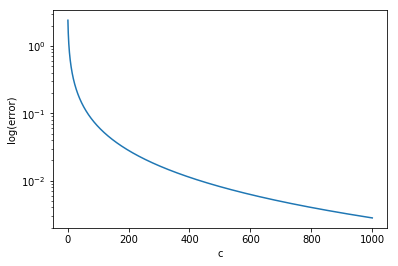

In [19]:
plt.semilogy(cs, mses)
plt.xlabel('c')
plt.ylabel('log(error)')
plt.show()

Ошибка уменьшается с ростом $c$. Но посмотрим на вектора весов и ответов:

In [20]:
names = Z.columns
for coef, name in zip (t, names):
    print(name, '\t', coef)

X 	 0.0015623092751705257
Y 	 -0.0002018990312792103
FFMC 	 0.00011244227873508528
DMC 	 8.753825285181718e-05
DC 	 -9.898304605997183e-06
ISI 	 -0.00042643840737602474
temp 	 0.0009510961277310048
RH 	 -0.00010535840958131619
wind 	 0.0012699688494148577
rain 	 -0.0011007491933284763
weekend 	 0.009329008250641507
summer 	 -0.01149881743219696
const 	 6.884240477979073


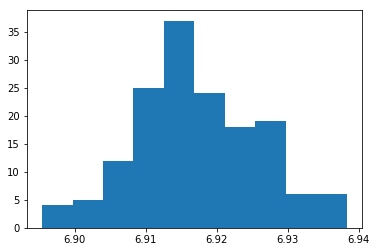

In [21]:
plt.hist(X_pred);

In [22]:
np.log(cs[-1])

6.9076552739818045

Видно, что модель просто выдает значения, близкие к $\log(c)$. А чем больше константа $c$, тем меньше ответы зависят от значений в датасете, то есть мы приближаемся к предсказыванию константы. Это подтверждается и тем, что веса всех признаков, кроме константного, становятся очень маленькими, а коэффициент при константе тоже примерно равен $\log(c)$.

#### 5. При выбранном $c$ сделаем разбиение выборки разными способами.

При перемешивании выборки в столбце `rain` в тренировочной части могут оказаться все нули, и мы не сможем обратить матрицу. Поэтому такие случаи будем пропускать.

In [23]:
N = 1000
mses_c = []
X_log = np.log(X + cs[-1])
for i in range(N):
    Z_train, Z_test, X_train, X_test = train_test_split(Z, 
                                X_log, test_size=0.3, shuffle=True)
    try:
        t = fit(Z_train, X_train)
    except np.linalg.LinAlgError:
        print('Bad shuffle')
    X_pred, mse = predict(t, Z_test, X_test)
    mses_c.append(mse)

Посмотрим на распределение ошибок на по-разному перемешанных выборках.

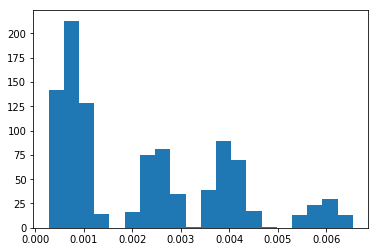

In [24]:
plt.hist(mses_c, bins=20);

Видим, что качество зависит от способа перемешивания, однако ошибка все равно остается маленькой, ее порядок не меняется. Причины этого были объяснены выше. 

#### 6. Вывод.

Ошибка предсказания площади пожара нашей моделью очень велика. Преобразование целевой переменной не улучшает ситуацию, и к тому же лишает предсказанные значения всякого смысла. Скорее всего, это происходит потому, что зависимость площади пожара от предоставленных данных не описывается линейной моделью. Нужно применять другие методы.